1)    Белый (Некоррелированный равномерный) шум
-      Спектральная плотность равномерна на всех частотах,
-      Значения некоррелированы,
2)    Розовый шум
-      Спектральная плотность обратно пропорциональна частоте,
-      Присутствует корреляция.
3)    Красный (Броуновский) шум
-      Спектральная плотность обратно пропорциональна квадрату частоты,
-      Присутствует корреляция.

На тройку:
Для каждого вида шумов:
1)    Построить амплитудный спектр,
2)    Проанализировать диапазон и характер распределения вероятностей значений,
3)    Построить корреляционную матрицу.


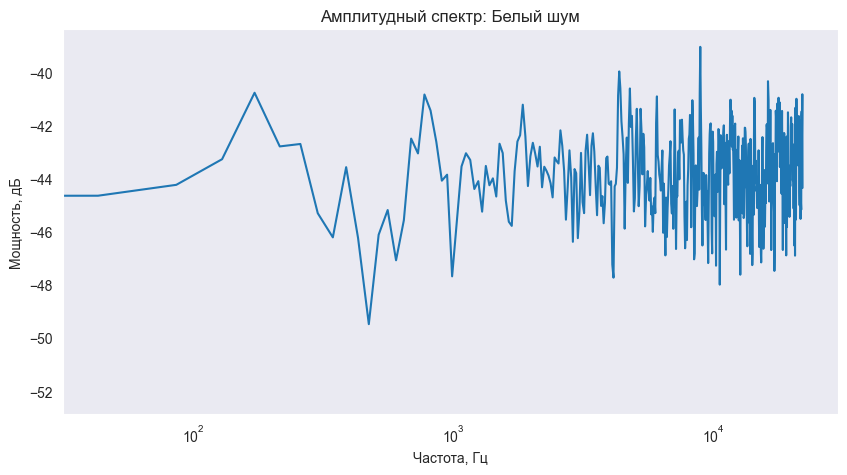

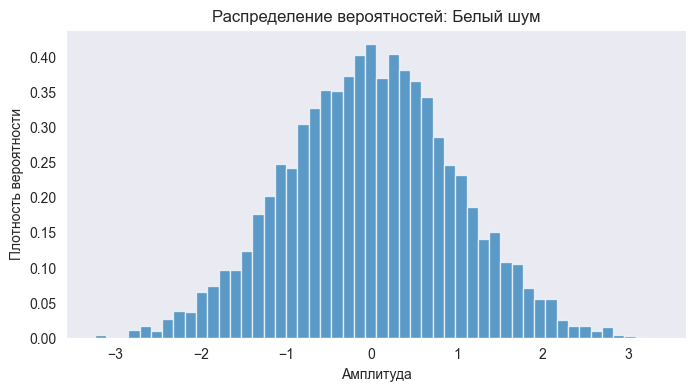

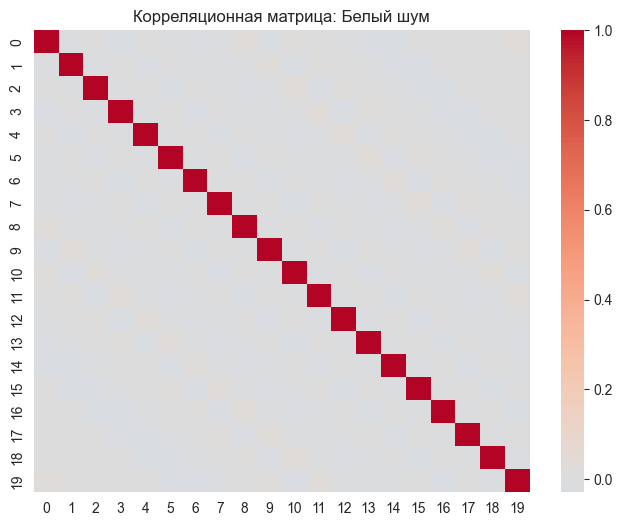

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import scipy.fftpack
import seaborn as sns
from scipy.io import wavfile

# --- Генерация шумов ---
def generate_white_noise(N):
    return np.random.normal(0, 1, N)

def generate_pink_noise(N):
    # Метод Voss-McCartney
    rows = int(np.ceil(np.log2(N)))
    array = np.random.randn(rows, N)
    pink = np.cumsum(array, axis=0)[-1]
    return (pink - np.mean(pink)) / np.std(pink)

def generate_red_noise(N):
    white = np.random.normal(0, 1, N)
    red = np.cumsum(white)
    return (red - np.mean(red)) / np.std(red)

# --- Построение амплитудного спектра ---
def plot_amplitude_spectrum(signal, fs, title):
    freqs, psd = scipy.signal.welch(signal, fs=fs, nperseg=1024)
    plt.figure(figsize=(10,5))
    plt.semilogx(freqs, 10*np.log10(psd))
    plt.title(f'Амплитудный спектр: {title}')
    plt.xlabel('Частота, Гц')
    plt.ylabel('Мощность, дБ')
    plt.grid()
    plt.show()

# --- Распределение вероятностей ---
def plot_probability_distribution(signal, title):
    plt.figure(figsize=(8,4))
    plt.hist(signal, bins=50, density=True, alpha=0.7)
    plt.title(f'Распределение вероятностей: {title}')
    plt.xlabel('Амплитуда')
    plt.ylabel('Плотность вероятности')
    plt.grid()
    plt.show()

# --- Корреляционная матрица ---
def plot_correlation_matrix(signal, title):
    # Формируем матрицу запаздываний
    X = np.column_stack([np.roll(signal, shift) for shift in range(20)])
    corr = np.corrcoef(X.T)
    plt.figure(figsize=(8,6))
    sns.heatmap(corr, cmap='coolwarm', center=0)
    plt.title(f'Корреляционная матрица: {title}')
    plt.show()

# --- Основной скрипт ---
def analyze_noise(signal, fs, title):
    plot_amplitude_spectrum(signal, fs, title)
    plot_probability_distribution(signal, title)
    plot_correlation_matrix(signal, title)

# --- Параметры ---
N = 5 * 1024  # количество отсчетов
fs = 44100    # частота дискретизации

# --- Генерация ---
white_noise = generate_white_noise(N)
pink_noise = generate_pink_noise(N)
red_noise = generate_red_noise(N)

# --- Анализ ---
analyze_noise(white_noise, fs, 'Белый шум')


Значения в белом шуме полностью независимы друг от друга, поэтому значения в корреляционной матрице > 0 только на главной диагонали. Распределение вероятностей имеет вид нормального распределения.

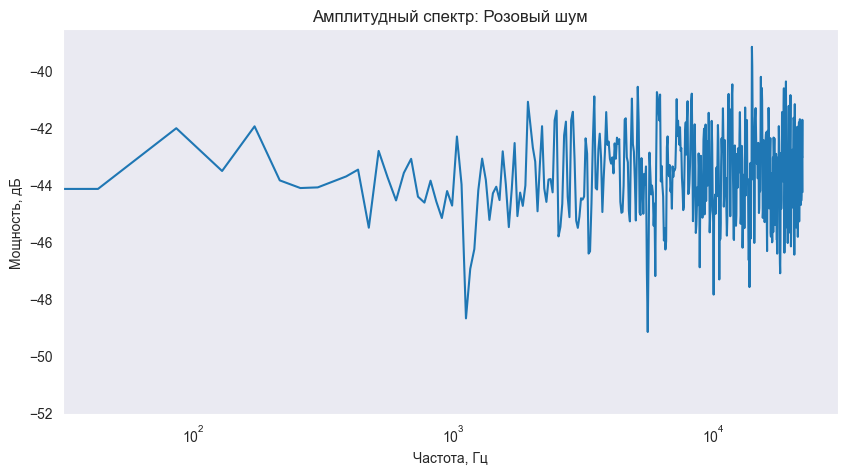

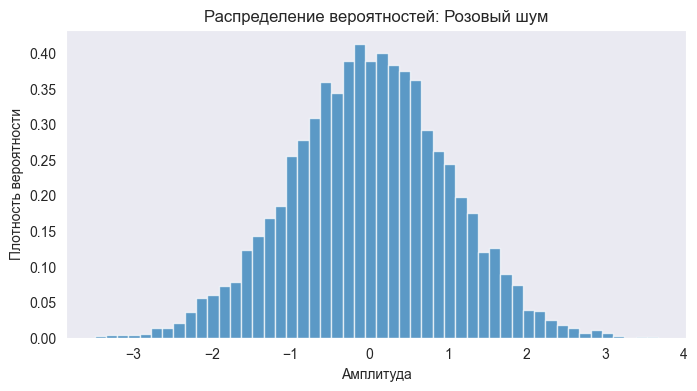

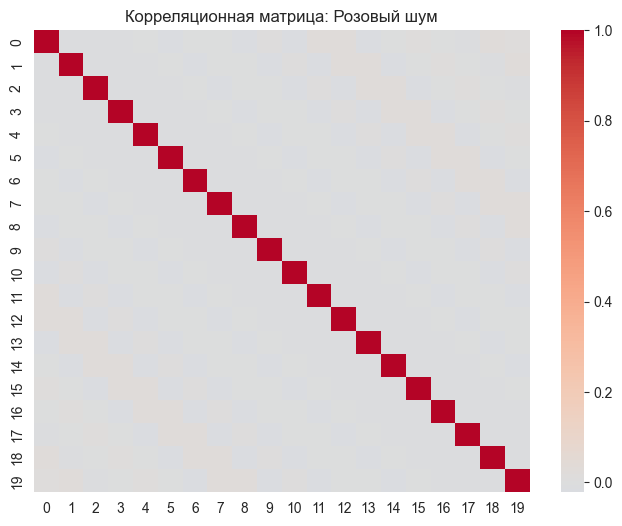

In [8]:
analyze_noise(pink_noise, fs, 'Розовый шум')

Корреляционная матрица и график распределения вероятностей похожи на те же показания белого шума.  

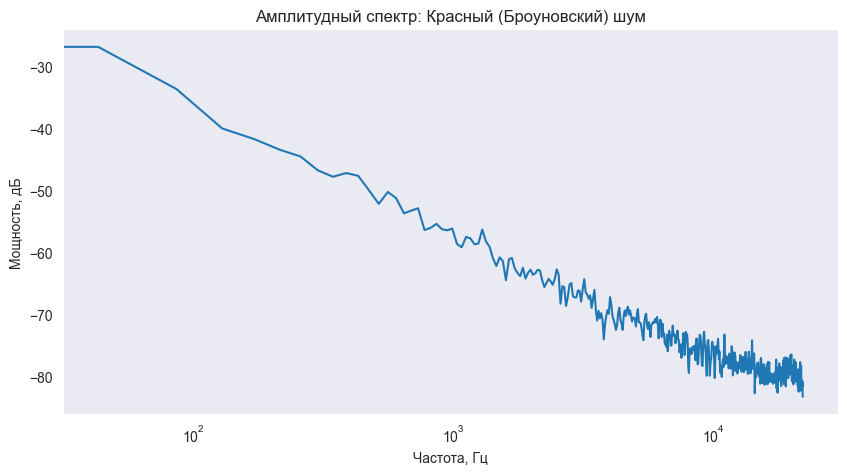

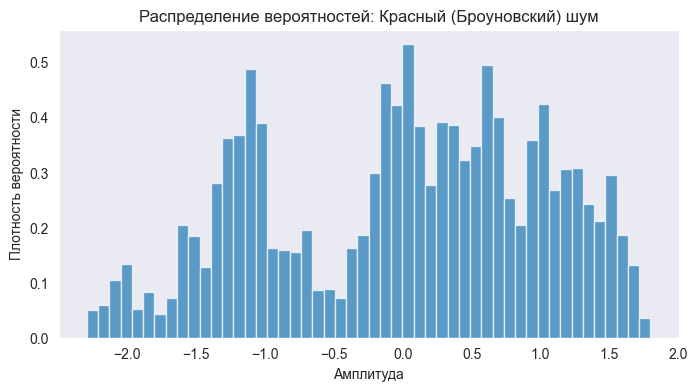

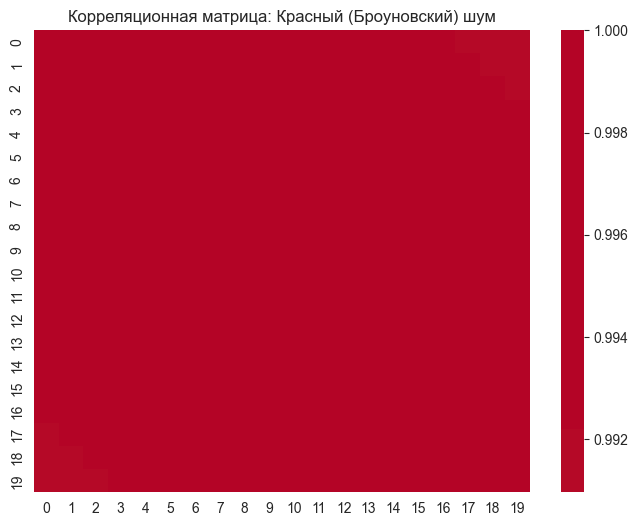

In [7]:
analyze_noise(red_noise, fs, 'Красный (Броуновский) шум')

В броуновском шуме сильная накопительная зависимость: каждый новый сэмпл строится как сумма всех предыдущих + случайная маленькая поправка. То есть отсчёты очень сильно связаны. Распределение вероятностей заметно отличается от белого и розового шумов: становится случайным и распределенным по всей амплитуде. 

***На четвёрку!***

Сделать запись своего голоса в помещении. Наложить шум (для первой группы – белый, для второй – розовый, для третьей – броуновский). Построить график, отображающий сигнал (голос) и шум на амплитудном спектре.

Посчитать отношение сигнала к шуму по средним значениям мощности. 

C:\Users\hello\AppData\Local\Temp\ipykernel_20456\451771389.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, data = wavfile.read(filename)


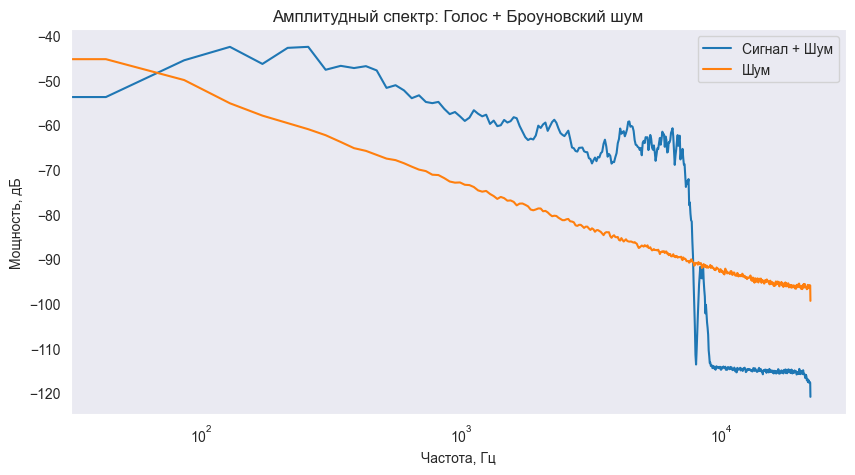

Фактическое отношение сигнал/шум: -17.20 дБ


In [17]:
def load_voice(filename):
    fs, data = wavfile.read(filename)
    if len(data.shape) > 1:  # Стерео в моно
        data = data.mean(axis=1)
    data = data / np.max(np.abs(data))  # Нормализация
    return fs, data

# Добавление шума к голосу
def add_noise(signal, noise, rate):
    signal_power = np.mean(signal**2)
    noise_power = np.mean(noise**2)
    k = np.sqrt(signal_power / (10**(rate/10) * noise_power))
    noisy_signal = signal + noise * k
    return noisy_signal

# Построение спектра сигнала + шума 
def plot_signal_and_noise(signal, noise, fs):
    freqs, signal_psd = scipy.signal.welch(signal, fs=fs, nperseg=1024)
    _, noise_psd = scipy.signal.welch(noise, fs=fs, nperseg=1024)

    plt.figure(figsize=(10,5))
    plt.semilogx(freqs, 10*np.log10(signal_psd), label='Сигнал + Шум')
    plt.semilogx(freqs, 10*np.log10(noise_psd), label='Шум')
    plt.title('Амплитудный спектр: Голос + Броуновский шум')
    plt.xlabel('Частота, Гц')
    plt.ylabel('Мощность, дБ')
    plt.legend()
    plt.grid()
    plt.show()


voice_file = 'voice.wav'  
fs_voice, voice = load_voice(voice_file)

# Подгоняем шум по длине к голосу
red_noise_voice = generate_red_noise(len(voice))

# Наложение броуновского шума на голос
rate = 10  
voice_with_noise = add_noise(voice, red_noise_voice, rate)

# Построение спектра голос + шум
plot_signal_and_noise(voice_with_noise, red_noise_voice, fs_voice)

# Расчет фактического SNR
signal_power = np.mean(voice**2)
noise_power = np.mean(red_noise_voice**2)
rate_actual = 10 * np.log10(signal_power / noise_power)
print(f'Фактическое отношение сигнал/шум: {rate_actual:.2f} дБ')